In [ ]:
!pip install xlrd
!pip install adversarial-robustness-toolbox
!pip install -U imbalanced-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 35.7 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 0.15.0 requires scikit-learn>=1.2.2, but you have scikit-learn 1.1.3 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.6/235.6 kB 2.0 MB/s eta 0:00:00
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.10.1
    Uninstalling imbalanced-learn-0.10.1:
      Successfully uninstalled imbalanced-learn-0.10.1


In [ ]:
import sys
import os
import pandas as pd
import numpy as np
import requests, io
import matplotlib.pyplot as plt
from google.colab import drive
from numpy import mean
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE,SVMSMOTE, KMeansSMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN, SMOTETomek
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from keras.layers import Dropout
from keras.constraints import MaxNorm
from sklearn.neighbors import NearestNeighbors
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from art.attacks.inference.membership_inference import MembershipInferenceBlackBox
from art.estimators.classification import KerasClassifier
from sklearn.metrics import classification_report

tf.compat.v1.disable_eager_execution()

drive.mount('/content/drive', force_remount=True)
DATA_PATH = '/content/drive/MyDrive/Colab Notebooks/'
#dataset = pd.read_excel(r"/content/drive/MyDrive/Colab Notebooks/default_of_credit_card_clients.xlsx")
dataset = pd.read_csv(r"/content/drive/MyDrive/Colab Notebooks/creditcard.csv")
dataset = dataset.dropna()
dataset['Class'].unique()
#print(dataset)
#dataset.head()

Mounted at /content/drive


array([0, 1])

In [ ]:
sm_dataset_0 = dataset.query("Class == 0")
sm_dataset_1 = dataset.query("Class == 1")
sm_dataset = pd.concat([sm_dataset_0[:40000], sm_dataset_1[:500]])
print(len(sm_dataset_0))
print(len(sm_dataset_1))
#scaler = MinMaxScaler()
#X_orig = sm_dataset.to_numpy()
#X_orig = scaler.fit_transform(X_orig)
#np.unique(X_orig[:-1])
#X_orig.shape

284315
492


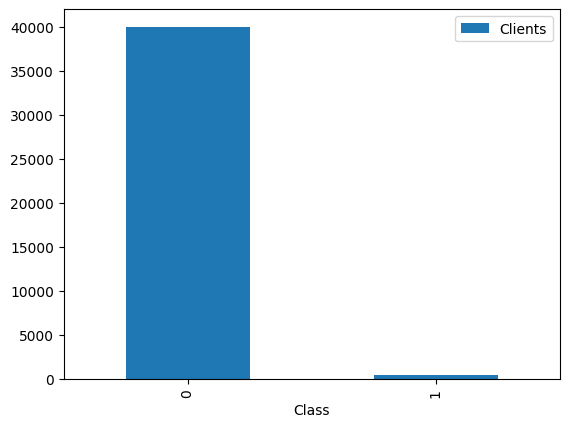

In [ ]:
#print(len(dataset.query("default_payment_next_month ==0")))
#print(len(dataset.query("default_payment_next_month ==1")))

data = {
  "Class": [0,1],
  "Clients": [len(sm_dataset.query("Class == 0")),
              len(sm_dataset.query("Class == 1"))]
}

#load data into a DataFrame object:
df = pd.DataFrame(data)

df.plot(kind = 'bar', x='Class',y = 'Clients')
plt.show()

In [ ]:
#smt = SMOTE()
#smt = ADASYN()
#smt = BorderlineSMOTE(random_state = 42, kind = 'borderline-1')
#smt = SMOTEENN(random_state=42)
#smt = SMOTETomek(random_state = 42)
#smt = SVMSMOTE(random_state = 42)
smt = KMeansSMOTE(random_state = 42)
X = sm_dataset.to_numpy()[:,:30]
y = sm_dataset.to_numpy()[:,-1]

X_train_3, y_train_3 = smt.fit_resample(X, y)

In [ ]:
"""Python implementation of SMOTE.
This implementation is based on the original variant of SMOTE.
Original paper: https://www.jair.org/media/953/live-953-2037-jair.pdf
"""

class PPSMOTE:

    def __init__(self, ratio=100, k_neighbors=2, random_state=None):
        if ratio > 0 and ratio < 100:
            self.ratio = ratio
        elif ratio >= 100:
            if ratio % 100 == 0:
                self.ratio = ratio
            else:
                raise ValueError(
                    'ratio over 100 should be multiples of 100')
        else:
            raise ValueError(
                'ratio should be greater than 0')

        if type(k_neighbors) == int:
            if k_neighbors > 0:
                self.k_neighbors = k_neighbors
            else:
                raise ValueError(
                    'k_neighbors should be integer greater than 0')
        else:
            raise TypeError(
                'Expect integer for k_neighbors')

        if type(random_state) == int:
            np.random.seed(random_state)

    def _laplaceNoise(self, mu, b, size):
        return np.random.laplace(mu, b, size)

    def _randomize(self, samples, ratio):
        length = samples.shape[0]
        target_size = length * ratio
        idx = np.random.randint(length, size=target_size)

        return samples[idx, :]

    def _populate(self, idx, nnarray):
        noise = self._laplaceNoise(0, 0.1538, 31)

        for i in range(self.N):
            nn = np.random.randint(low=0, high=self.k_neighbors)
            for attr in range(self.numattrs):
                dif = (self.samples[nnarray[nn]][attr] - self.samples[idx][attr])
                #gap = np.random.uniform()
                self.synthetic[self.newidx][attr] = (self.samples[idx][attr] + noise[attr] * dif)
            self.newidx += 1

    def oversample(self, samples, merge=False):

        if type(samples) == list:
            self.samples = np.array(samples)
        elif type(samples) == np.ndarray:
            self.samples = samples
        else:
            raise TypeError(
                'Expect a built-in list or an ndarray for samples')

        self.numattrs = self.samples.shape[1]

        if self.ratio < 100:
            ratio = ratio / 100.0
            self.samples = self._randomize(self.samples, ratio)
            self.ratio = 100

        self.N = int(self.ratio / 100)
        new_shape = (self.samples.shape[0] * self.N, self.samples.shape[1])
        self.synthetic = np.empty(shape=new_shape)
        self.newidx = 0

        self.nbrs = NearestNeighbors(n_neighbors=self.k_neighbors)
        self.nbrs.fit(samples)
        self.knn = self.nbrs.kneighbors()[1]

        for idx in range(self.samples.shape[0]):
            nnarray = self.knn[idx]
            self._populate(idx, nnarray)

        if merge:
            return np.concatenate((self.samples, self.synthetic))
        else:
            return self.synthetic
smt = PPSMOTE(ratio=100, k_neighbors=2)
synthetic_samples = smt.oversample(sm_dataset_1.to_numpy())
pp_sm_dataset = smt.oversample(sm_dataset_1.to_numpy(), merge=True)
sm_dataset_1=pd.DataFrame(pp_sm_dataset)
pp_sm_dataset.shape

(31488, 31)

In [ ]:
X_train_1 = sm_dataset_0.to_numpy()[1:31488,:]
X_train_2 = sm_dataset_1.to_numpy()[1:31488,:]
X_train_3 =np.concatenate((X_train_1,X_train_2),axis=0)
X_train_3.shape
#np.unique(X_train_3[:,-1])

(31978, 31)

In [ ]:
def _splitData(X_train_3):
  #X_train, X_test, y_train, y_test = train_test_split(X_train_3[:,:30],X_train_3[:,-1], random_state=104,test_size=0.5,shuffle=True)
  X_train, X_test, y_train, y_test = train_test_split(X_train_3,y_train_3, random_state=104,test_size=0.5,shuffle=True)
  scaler = MinMaxScaler()
  label_encoder = LabelEncoder()
  X_train = scaler.fit_transform(X_train)
  X_test = scaler.fit_transform(X_test)
  label_encoder.fit(y_train)
  label_encoder.fit(y_test)
  y_train = label_encoder.transform(y_train)
  y_test = label_encoder.transform(y_test)
  return X_train, X_test, y_train, y_test

def _buildModel(X_train, X_test, y_train, y_test):
  os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
  optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.001)
  loss = tf.keras.losses.BinaryCrossentropy()

  model = Sequential()
  model.add(Dense(30, activation='relu', input_dim=30, kernel_constraint=MaxNorm(3)))
  model.add(Dropout(0.3))
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.3))
  model.add(Dense(32, activation='relu'))
  model.add(Dropout(0.3))
  model.add(Dense(16, activation='relu'))
  model.add(Dropout(0.3))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
  #model.summary()
  history = model.fit(X_train, y_train,
                        validation_data=(X_test, y_test),
                        batch_size=128,
                        epochs=30,
                        verbose=0)
  pred_val = model.predict(X_test)
  fpr, tpr, threshold = roc_curve(y_test, pred_val, pos_label=1)

  random_pred_val = [0 for i in range(len(y_test))]
  p_fpr1, p_tpr1, _ = roc_curve(y_test, random_pred_val, pos_label=1)
  auc_score = roc_auc_score(y_test, pred_val)
  #print(f"AUC SCORE: {auc_score:6f}")
  return model, auc_score

def calc_precision_recall(predicted, actual, positive_value=1):
    score = 0  # both predicted and actual are positive
    num_positive_predicted = 0  # predicted positive
    num_positive_actual = 0  # actual positive
    for i in range(len(predicted)):
        if predicted[i] == positive_value:
            num_positive_predicted += 1
        if actual[i] == positive_value:
            num_positive_actual += 1
        if predicted[i] == actual[i]:
            if predicted[i] == positive_value:
                score += 1

    if num_positive_predicted == 0:
        precision = 1
    else:
        precision = score / num_positive_predicted  # the fraction of predicted “Yes” responses that are correct
    if num_positive_actual == 0:
        recall = 1
    else:
        recall = score / num_positive_actual  # the fraction of “Yes” responses that are predicted correctly
    return precision, recall

def _attackMIA(X_train, X_test, y_train, y_test, model):
  attack_train_ratio = 0.5
  attack_train_size = int(len(X_train) * attack_train_ratio)
  attack_test_size = int(len(X_test) * attack_train_ratio)

  mlp_art_model = KerasClassifier(model=model, clip_values=(0, 1))

  mlp_attack_bb = MembershipInferenceBlackBox(mlp_art_model, attack_model_type='rf')

  mlp_attack_bb.fit(X_train[:attack_train_size].astype(np.float32),y_train[:attack_train_size].astype(np.float32),
                    X_test[:attack_test_size].astype(np.float32), y_test[:attack_test_size].astype(np.float32))

  mlp_inferred_train_bb = mlp_attack_bb.infer(X_train[attack_train_size:].astype(np.float32), y_train[attack_train_size:])
  mlp_inferred_test_bb = mlp_attack_bb.infer(X_test[attack_test_size:].astype(np.float32), y_test[attack_test_size:])

  mlp_train_acc_bb = np.sum(mlp_inferred_train_bb) / len(mlp_inferred_train_bb)
  mlp_test_acc_bb = 1-(np.sum(mlp_inferred_test_bb) / len(mlp_inferred_test_bb))
  mlp_acc_bb = (mlp_train_acc_bb * len(mlp_inferred_train_bb) + mlp_test_acc_bb * len(mlp_inferred_test_bb)) / (len(mlp_inferred_train_bb) + len(mlp_inferred_test_bb))

  #print(f"Members Accuracy: {mlp_train_acc_bb:.4f}")
  #print(f"Non Members Accuracy {mlp_test_acc_bb:.4f}")
  #print(f"Attack Accuracy {mlp_acc_bb:.4f}")

  precision, recall = calc_precision_recall(np.concatenate((mlp_inferred_train_bb, mlp_inferred_test_bb)),
                              np.concatenate((np.ones(len(mlp_inferred_train_bb)), np.zeros(len(mlp_inferred_test_bb)))))
  y_train_pred = np.concatenate((mlp_inferred_train_bb, mlp_inferred_test_bb))
  y_train_true = np.concatenate((np.ones_like(mlp_inferred_train_bb), np.zeros_like(mlp_inferred_test_bb)))
  #print(classification_report(y_pred=y_train_pred, y_true=y_train_true))
  return mlp_train_acc_bb, mlp_test_acc_bb, mlp_acc_bb, precision, recall


In [ ]:
import concurrent.futures
import threading

num_iterations = 20
auc = []
member  = []
nonmember = []
att = []
prec = []
rec = []

def execAttack(lock):
  with lock:
    #print("Attack executed.")
    X_train, X_test, y_train, y_test = _splitData(X_train_3)
    model, auc_score = _buildModel(X_train, X_test, y_train, y_test)
    mlp_train_acc_bb, mlp_test_acc_bb, mlp_acc_bb, precision, recall = _attackMIA(X_train, X_test, y_train, y_test, model)
    #print(f"AUC SCORE,Members Accuracy,Non Members Accuracy,Attack Accuracy,Attack Precision,Attack Recall")
    print(f"{auc_score:4f},{mlp_train_acc_bb:4f},{mlp_test_acc_bb:4f},{mlp_acc_bb:4f},{precision:4f},{recall:4f}")
    auc.append(auc_score)
    member.append(mlp_train_acc_bb)
    nonmember.append(mlp_test_acc_bb)
    att.append(mlp_acc_bb)
    prec.append(precision)
    rec.append(recall)

with concurrent.futures.ThreadPoolExecutor() as executor:
    lock = threading.Lock()
    futures = [executor.submit(execAttack,lock) for _ in range(num_iterations)]
    concurrent.futures.wait(futures)
ppldf = pd.DataFrame()
ppldf['AUC'] = np.array(auc)
ppldf['Member_Accuracy'] = np.array(member)
ppldf['Non_Member_Accuracy'] = np.array(nonmember)
ppldf['Attack_accuracy'] = np.array(att)
ppldf['Precision'] = np.array(prec)
ppldf['Recall'] = np.array(rec)
#ppldf.head()
ppldf.to_csv("/content/drive/MyDrive/Colab Notebooks/results/result_KMEANSSMOTE.csv")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


0.999923,0.523950,0.509850,0.516900,0.516665,0.523950


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


0.999846,0.976250,0.036750,0.506500,0.503351,0.976250


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


0.999856,0.559550,0.501650,0.530600,0.528925,0.559550


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


0.999894,0.988500,0.042150,0.515325,0.507874,0.988500


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


0.999841,0.498550,0.542100,0.520325,0.521250,0.498550


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


0.999881,0.504800,0.504900,0.504850,0.504850,0.504800


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


0.999887,0.696400,0.449700,0.573050,0.558595,0.696400


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


0.999873,0.704250,0.442450,0.573350,0.558131,0.704250


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


0.999896,0.985900,0.036850,0.511375,0.505836,0.985900


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


0.999897,0.992950,0.023600,0.508275,0.504202,0.992950


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


0.999873,0.935800,0.247350,0.591575,0.554236,0.935800


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


0.999882,0.981950,0.090000,0.535975,0.519015,0.981950


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


0.999827,0.957400,0.395900,0.676650,0.613128,0.957400


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


0.999876,0.589800,0.487050,0.538425,0.534845,0.589800


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


0.999924,0.919000,0.318150,0.618575,0.574070,0.919000


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


0.999889,0.509250,0.506450,0.507850,0.507828,0.509250


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


0.999863,0.993200,0.283650,0.638425,0.580972,0.993200


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


0.999806,0.983900,0.164500,0.574200,0.540783,0.983900


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


0.999855,0.505000,0.502250,0.503625,0.503615,0.505000


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


0.999869,0.512900,0.498650,0.505775,0.505694,0.512900


In [ ]:
#plt.plot(fpr, tpr, linestyle='--',color='red', label='Artificial Neural Network')
#plt.plot(p_fpr1, p_tpr1, linestyle='--', color='black')
#plt.title('ROC curve plot')
#plt.xlabel('False Positive Rate / FPR')
#plt.ylabel('True Positive rate / TPR')
#plt.legend(loc='best')
#plt.savefig('ROC',dpi=300)
#plt.show();

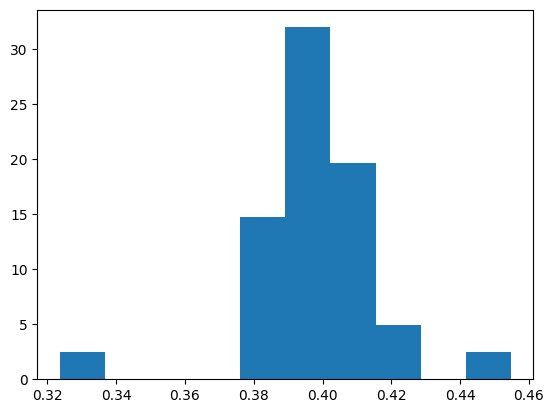

In [ ]:
# import numpy
import numpy as np
import matplotlib.pyplot as plt

# Using numpy.random.laplace() method
gfg = np.random.laplace(0.4, 0.014, 31)

count, bins, ignored = plt.hist(gfg,10, density = True)
plt.show()


In [ ]:
import numpy as np
import math


# Define your dataset as a multidimensional array (e.g., a NumPy array)
dataset = X_orig

# Initialize L1 norm sensitivity to 0
l1_norm_sensitivity = 0

# Iterate through each data point in the dataset
for i, data_point in enumerate(dataset):
    # Create a temporary dataset by removing the i-th data point
    temp_dataset = np.delete(dataset, i, axis=0)

    # Calculate the L1 norm for the original dataset and the temporary dataset
    l1_norm_orig = np.linalg.norm(dataset, ord=1)  # L1 norm of the original dataset
    l1_norm_temp = np.linalg.norm(temp_dataset, ord=1)  # L1 norm of the temporary dataset

    # Calculate the absolute difference in L1 norms
    diff = abs(l1_norm_orig - l1_norm_temp)

    # Update l1_norm_sensitivity if the calculated difference is greater
    l1_norm_sensitivity = max(l1_norm_sensitivity, diff)

# l1_norm_sensitivity now contains the L1 norm sensitivity of the dataset
print("L1 Norm Sensitivity:",l1_norm_sensitivity)


L1 Norm Sensitivity: 1.0


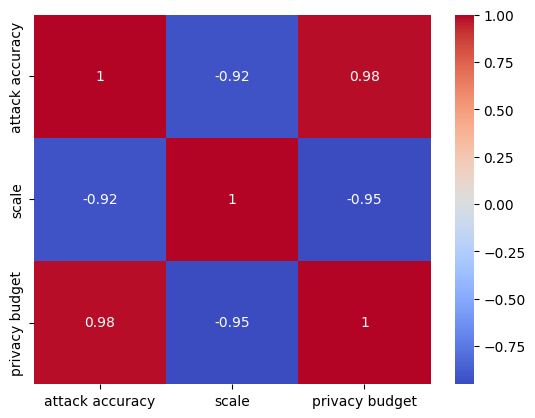

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Sample data (replace with your actual data)
data = pd.DataFrame({'attack accuracy': [0.66096117,0.66186497,0.6379094,0.62055228,0.61616268,0.61460011],
#[0.62493807, 0.60850006, 0.60826188, 0.61125667, 0.60358867, 0.59441374, 0.5812897, 0.58490377, 0.57828855, 0.59338637, 0.59669557 ],
#0.51801962,0.51629999,0.51636541,0.51693334,0.5154358,0.51652791,0.51576831,0.51525038,0.51561872,0.5159154
                     'scale' : [0.0125,0.014286,0.02,0.025,0.033333,0.04],
#[0.01,0.02,0.03333,0.04,0.05,0.1,0.125,0.111,0.142857,0.166667,0.2],
#0.002,0.005,0.0083333,0.01,0.0125,0.014286,0.016667,0.02,0.025,0.03333
                     'privacy budget': [80,70,50,40,30,25]
#[100,50,30,25,20,10,8,9,7,6,5]
#500,200,120,100,80,70,60,50,40,30
                     })

# Calculate and display Pearson correlation coefficients
correlation_matrix = data.corr(method='pearson')
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.show()
